In [33]:
# some of the following based on tutorial from https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

import logging
import pandas as pd
import numpy as np
from numpy import random

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

df = pd.read_csv('reddit-comment-classification-comp-551/reddit_train.csv')
df = df[pd.notnull(df['comments'])]
# print(df.head(10))
# print(df['comments'].apply(lambda x: len(x.split(' '))).sum())

X_kaggle = pd.read_csv('reddit-comment-classification-comp-551/reddit_test.csv')
X_kaggle = X_kaggle[pd.notnull(X_kaggle['comments'])]
# print(X_kaggle.head(10))
# print(X_kaggle['comments'].apply(lambda x: len(x.split(' '))).sum())

In [34]:
import nltk
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

delimiters = re.compile('[/(){}\[\]\|@,;]')
ignored_symbols = re.compile('[^0-9a-z #+_]')
# nltk.download('stopwords')
stopwords = set(stopwords.words('english'))


def clean_text(text):
    """
        text: a string (one comment)
        return: modified string
    """
#     text = BeautifulSoup(text, "lxml").text # HTML decoding # our pipeline does slightly better without this.
    text = text.lower() # lowercase text
    text = delimiters.sub(' ', text) # replace delimiters symbols by space in text
    text = ignored_symbols.sub('', text) # delete symbols which are in ignored_symbols from text
    text = ' '.join(word for word in text.split() if word not in stopwords) # delete stopwords from text
    return text
    
df['comments'] = df['comments'].apply(clean_text)

#COMPETITION SET
X_kaggle['comments'] = X_kaggle['comments'].apply(clean_text)


In [35]:
from nltk.tokenize import word_tokenize

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem_sentence(sen):
    """ stems every word in space separated sentence sen """ 
    token_list = word_tokenize(sen)
    stem_sen = []
    for w in token_list:
        stem_sen.append(stemmer.stem(w))
    return " ".join(stem_sen)


# choose lemm_sentence)() for lemmatization, or stem_sentence() for stemming.
df['comments'] = df['comments'].apply(lambda x: stem_sentence(x))

# print_plot(1234)
print(df.head(1))

#COMPETITION SET
# choose lemm_sentence)() for lemmatization, or stem_sentence() for stemming.
X_kaggle['comments'] = X_kaggle['comments'].apply(lambda x: stem_sentence(x))
X_kaggle = pd.Series(X_kaggle['comments'], index=X_kaggle.index)

   id                                           comments subreddits
0   0  honestli buffalo correct answer rememb peopl s...     hockey


In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.comments, df.subreddits, test_size=0.3, random_state = 27)
values_array = np.unique(df.subreddits.values)

In [37]:
import seaborn as sns
def print_confusion_matrix(confusion_matrix, class_names, 
                           figsize = (9,6), fontsize=14, title='Confusion matrix'):
    """Prints a sklearn.metrics.confusion_matrix"""
    accuracy = np.trace(confusion_matrix) / float(np.sum(confusion_matrix))
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
#     heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#     heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='center')
    heatmap.set_ylim(len(class_names), -0.5)
    plt.ylabel('Actual subreddit')
    plt.xlabel('Predicted subreddit')
    plt.title(title+'\naccuracy={:0.4f}'.format(accuracy))
    plt.tight_layout()

{}
VotingClassifier model
accuracy 0.5797619047619048
                 precision    recall  f1-score   support

      AskReddit       0.25      0.32      0.28      1003
GlobalOffensive       0.71      0.68      0.70      1030
          Music       0.67      0.66      0.67      1050
      Overwatch       0.70      0.69      0.69      1049
          anime       0.63      0.65      0.64      1056
       baseball       0.72      0.62      0.67      1060
         canada       0.44      0.51      0.47      1030
     conspiracy       0.41      0.47      0.44      1047
         europe       0.52      0.55      0.53      1039
          funny       0.25      0.21      0.23      1084
  gameofthrones       0.79      0.74      0.76      1083
         hockey       0.69      0.62      0.65      1059
leagueoflegends       0.74      0.65      0.69      1043
         movies       0.58      0.62      0.60      1051
            nba       0.67      0.66      0.67      1025
            nfl       0.68      0

<IPython.core.display.Javascript object>


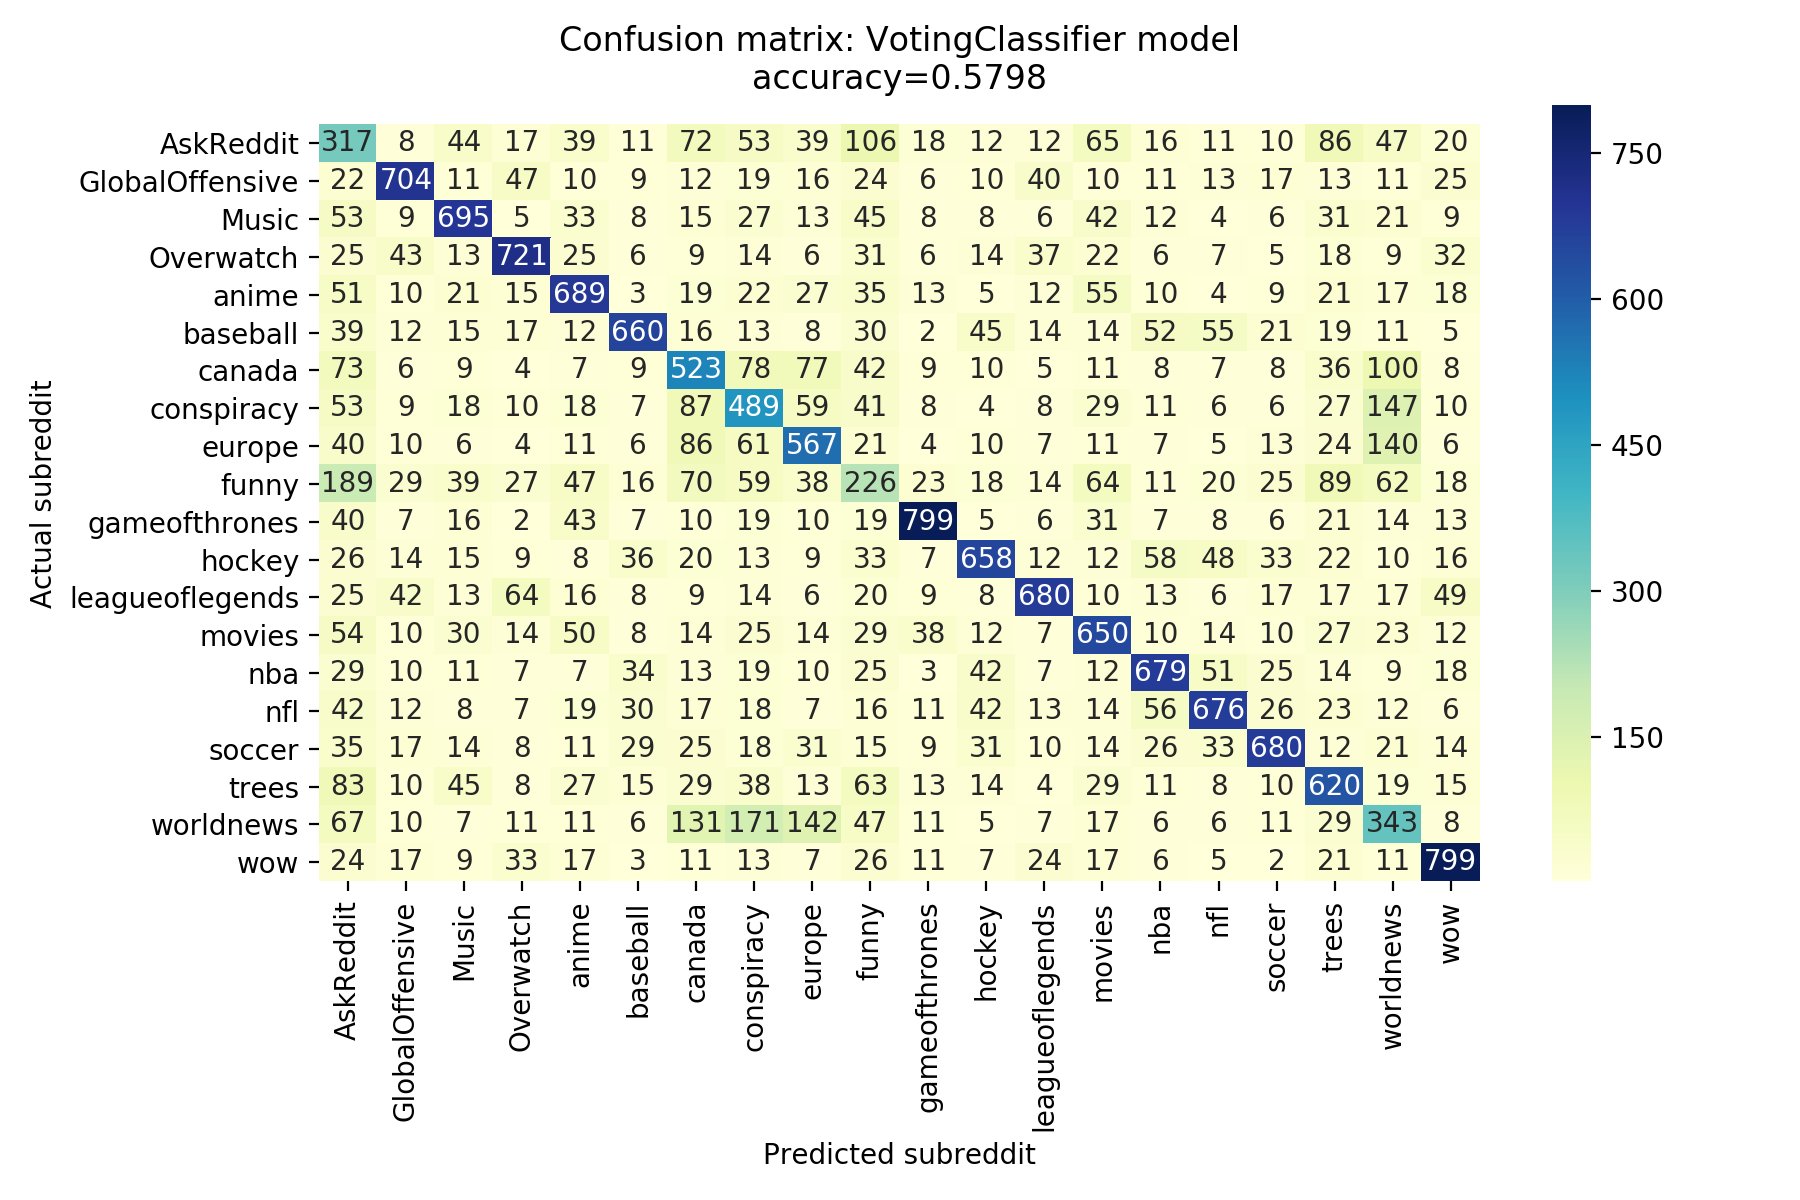

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

from sklearn.naive_bayes import BernoulliNB
bernoulli_nb = Pipeline([
                         ('ct_vect', CountVectorizer(binary=True)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', BernoulliNB(alpha=0.1)),
                        ])

from sklearn.naive_bayes import MultinomialNB
multinomial_nb = Pipeline([
                         ('ct_vect', CountVectorizer(binary=False)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', MultinomialNB(alpha=0.1)),
                        ])

from sklearn.naive_bayes import ComplementNB
complement_nb = Pipeline([
                         ('ct_vect', CountVectorizer(binary=False)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', ComplementNB(alpha=2)),
                        ])

from sklearn.linear_model import SGDClassifier
sgd = Pipeline([
                 ('ct_vect', CountVectorizer(ngram_range=(1,2))),
                 ('tfidf', TfidfTransformer()),
                 ('clf', SGDClassifier(loss='modified_huber', penalty='l2',
                                       alpha=1e-4, random_state=27,
                                       max_iter=5, tol=None)),
                ])

from sklearn.neighbors import KNeighborsClassifier
knn = Pipeline([
                 ('ct_vect', CountVectorizer(ngram_range=(1,1))),
                 ('tfidf', TfidfTransformer()),
                 ('clf', KNeighborsClassifier(n_neighbors=300, weights = 'distance')),
                ])

from sklearn.linear_model import LogisticRegression
logreg = Pipeline([
                 ('ct_vect', CountVectorizer()), # works well with more features (all 75440 ...)
                 ('tfidf', TfidfTransformer()),
                 ('clf', LogisticRegression(penalty='l2',multi_class='ovr',solver='saga')),
                ])


from sklearn.ensemble import RandomForestClassifier
randfrst = Pipeline([
                 ('ct_vect', CountVectorizer()),
                 ('feature_selection', SelectFromModel(LinearSVC(C=0.1, penalty="l1", dual=False))), # optional
                 ('tfidf', TfidfTransformer()),
                 ('clf', RandomForestClassifier(n_estimators=200)), # more estimators might be good, but slow
                ])

from sklearn.neural_network import MLPClassifier
mlp = Pipeline([
                 ('ct_vect', CountVectorizer(max_features=5000)),
                 ('tfidf', TfidfTransformer()),
                 ('clf', MLPClassifier(alpha=1, max_iter=100)),
                ])

from sklearn.linear_model import PassiveAggressiveClassifier
passaggr = Pipeline([
                 ('ct_vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', PassiveAggressiveClassifier(fit_intercept=True,C=0.1)),
                ])

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import FunctionTransformer
lda =  Pipeline([
                 ('ct_vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('todense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
                 ('clf', LinearDiscriminantAnalysis()),
                ])

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda =  Pipeline([
                 ('ct_vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('todense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
                 ('clf', QuadraticDiscriminantAnalysis()),
                ])

# now for comparing and majority voting:
from sklearn.ensemble import VotingClassifier
clf1 = LogisticRegression(penalty='l2',multi_class='ovr',solver='lbfgs')#l2, ovr, newton-cg try lbfgs
clf2 = MultinomialNB(alpha=0.08) #0.25 27
clf3 = ComplementNB(alpha=0.008) #0.01 008
clf4 = PassiveAggressiveClassifier(fit_intercept=True,C=0.1) # won't work with voting='soft'!
clf5 = SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-4, random_state=27,max_iter=5, tol=None)
clf6 = KNeighborsClassifier(n_neighbors=300, weights = 'distance')
clf7 = BernoulliNB(alpha=0.01,binarize=0.0)

voting_clf = Pipeline([
    ('ct_vect', CountVectorizer(binary=False,ngram_range=(1,1))),
    ('tfidf', TfidfTransformer()),
    ('clf' , VotingClassifier(estimators=
                              [('logreg', clf1), ('mnb', clf2), ('cnb', clf3)],
                              voting='soft',n_jobs=-1))
])



parameters = {
        #passagr
#         'clf__C':[0.5,0.1,0.01]
        #voting
#          'clf__voting': ['hard','soft'],
#         'clf__estimators':[
#             [('logreg', clf1), ('mnb', clf2), ('cnb', clf3)], # best acc after training on whole train set
#             [('sgd', clf5), ('mnb', clf2), ('cnb', clf3)],    # best acc in 3-fold cv, but not best after training on whole train set
#             [('logreg', clf1), ('cnb', clf3),('sgd', clf5)],
#             [('passaggr', clf4), ('cnb', clf3),('sgd', clf5)],
#             [('passaggr', clf4), ('mnb', clf2), ('cnb', clf3)],
#         ]
#         'clf__mnb__alpha': [0.04,0.06,0.08],
#         'clf__cnb__alpha': [1,0.001,0.008],
        #logreg
#         'ct_vect__ngram_range': [(1,1)],
#         'ct_vect__max_features': [1000,5000,74000],
#         'clf__multi_class':['ovr','multinomial'],
#         'clf__solver':['sag','saga'],
        
#       #knn
#         'ct_vect__ngram_range': [(1,1)],
#         'ct_vect__max_features': [5000,74000],
#         'clf__n_neighbors':[3,30],
        
        #bernoulli_nb
#         'ct_vect__ngram_range': [(1,1)],
#         'ct_vect__max_features': [10000],
#         'clf__alpha': [1,1e-2,1e-3],
        
        #sgd
#        'ct_vect__ngram_range': [(1,1),(1,2)],
#         'ct_vect__max_features': [5000,74400],
#         'clf__alpha': [1e-3, 1e-5],
#         'clf__loss': ['modified_huber', 'hinge','log','epsilon_insensitive'],
    }

def paramsearch(modelpipeline,parameters):
    '''
    modelpipeline: sklearn.pipeline.Pipeline object 
    does gridsearch on the given pipeline on test split and prints classification report
    '''
    from sklearn.model_selection import GridSearchCV

    # run gridsearch for parameters with 3-fold cross validation
    gridsearch = GridSearchCV(modelpipeline, parameters, cv=3, iid=False, n_jobs=-1)
    gridsearchfit = gridsearch.fit(X_train, y_train)
    y_pred = gridsearchfit.predict(X_test)
    print(gridsearchfit.best_params_)
    #print(gridsearchfit.best_score_)
    print('%s model'%(type(modelpipeline['clf'])).__name__)
    print('accuracy %s' % accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=values_array))
    cm = confusion_matrix(y_test,y_pred)
    print_confusion_matrix(cm, values_array, 
                       figsize = (9,6), fontsize=14, 
                       title='Confusion matrix: %s model'%(type(modelpipeline['clf'])).__name__)
    return gridsearchfit

def runmodel(modelpipeline):
    '''
    modelpipeline: sklearn.pipeline.Pipeline object 
    runs the given pipeline on test split and prints classification report
    '''
    modelpipeline.fit(X_train, y_train)
    y_pred = modelpipeline.predict(X_test)
    # print(modelpipeline)
    print('accuracy %.3f' % accuracy_score(y_test, y_pred))
    # print(classification_report(y_test, y_pred,target_names=values_array))
    print(confusion_matrix(y_test, y_pred))
    

ourmodel = paramsearch(voting_clf,parameters)

In [40]:
# y_pred = ourmodel.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# labels = values_array
    
# print_confusion_matrix(cm, labels, figsize = (8,6), fontsize=10)

In [39]:
#MAKE PREDICTIONS FOR THE HELDOUT COMPETITION SET
y_kaggle = ourmodel.predict(X_kaggle)
y_kaggle = pd.Series(y_kaggle, index=X_kaggle.index)
y_kaggle = pd.DataFrame(y_kaggle)
y_kaggle['Id_'] = y_kaggle.index
y_kaggle.insert(loc = 0, column = "Id", value = y_kaggle['Id_'])
y_kaggle = y_kaggle.drop(columns=['Id_'])
y_kaggle = y_kaggle.rename(columns={0: "Category"})
y_kaggle

,Id,Category
0,0,baseball
1,1,europe
2,2,anime
3,3,worldnews
4,4,trees
...,...,...
29995,29995,movies
29996,29996,AskReddit
29997,29997,GlobalOffensive
29998,29998,gameofthrones


In [41]:
## Print out the predictions to a csv
y_kaggle.to_csv("predictions5798.csv", index=False, sep = ',') 